### Install libraries


In [1]:
!pip install -r ../dev-requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: '../dev-requirements.txt'

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


### Load Data

In [2]:
import pandas as pd
import os

folder = os.path.join("../../data/binance_1d")
dfs = []
for file in os.listdir(folder):
    if file.endswith(".csv"):
        dfs.append(pd.read_csv(os.path.join(folder, file), skiprows=1))
print(dfs.__len__())

# For the first dataframe, print summary, info, and head
print(dfs[0].describe())
print(dfs[0].info())
print(dfs[0].head())

286
               Unix         Open         High          Low        Close  \
count  1.147000e+03  1147.000000  1147.000000  1147.000000  1147.000000   
mean   1.648080e+12  1845.627175  1859.073348  1832.683653  1845.483644   
std    2.862040e+10    87.541430    89.218886    87.152481    87.582019   
min    1.598573e+12  1620.000000  1633.000000  1606.000000  1619.000000   
25%    1.623326e+12  1787.500000  1799.000000  1775.075000  1787.805000   
50%    1.648080e+12  1844.680000  1859.000000  1832.000000  1844.000000   
75%    1.672834e+12  1910.800000  1923.800000  1900.000000  1911.755000   
max    1.697587e+12  2053.000000  2100.850000  2030.000000  2053.000000   

        Volume PAXG   Volume USDT     tradecount  
count   1147.000000  1.147000e+03    1147.000000  
mean    2152.501644  3.982047e+06    8203.450741  
std     2965.837580  5.679698e+06    8454.528583  
min       15.584449  2.917958e+04     234.000000  
25%      676.345500  1.238778e+06    3849.000000  
50%     1414.7

### Merge all data into one dataframe

In [3]:
import pandas as pd

# Step 1: Convert "date" column to datetime in all dataframes
for df in dfs:
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors="coerce")

# Step 2: Find the oldest and newest dates across all dataframes
all_dates = [df['Date'] for df in dfs]
all_dates_flat = [date for sublist in all_dates for date in sublist if not pd.isnull(date)]

oldest_date = '2019-01-01'
newest_date = max(all_dates_flat)

# Step 3: Create a new dataframe with the date range
date_range = pd.date_range(start=oldest_date, end=newest_date, freq='D')  # Daily frequency
merged_df = pd.DataFrame({'Date': date_range})

# Step 4: Add "close" and "Volume USDT" columns from each dataframe to the merged_df using list comprehension
for df in dfs:
    try:
        ticker = df['Symbol'].iloc[0]  # Assuming each dataframe has a "symbol" column
        close_col_name = f'close_{ticker}'
        volume_col_name = f'Volume USDT_{ticker}'  # Replace with the actual column name if it's different in your data

        df = df.set_index('Date').sort_index()

        # Create DataFrames with the "date" and "close" columns
        close_data = df[df.index.isin(date_range)][['Close']]
        close_data.rename(columns={'Close': close_col_name}, inplace=True)

        # Merge the "close_data" into the "merged_df"
        merged_df = pd.merge(merged_df, close_data, left_on='Date', right_index=True, how='left')

        # Add the "Volume USDT" column to the merged_df (replace 'Volume USDT' with the actual column name if it's different)
        # merged_df[volume_col_name] = df['Volume USDT']

    except ValueError as e:
        print(f'Error on coin {ticker}: {e}')


# print number of columns -1 of merged_df
print(merged_df.columns.__len__()-1)

286


In [4]:
# drop columns with NaN values
merged_df.dropna(axis=1, inplace=True)
print(merged_df.columns.__len__()-1)

17


In [5]:
# # copy the files of the merged_df columns to airflow/assets
# columns = [col.replace("close_", "") for col in merged_df.columns[1:]]
# for col in columns:
#     os.system(f"cp ../data/binance_1d/Binance_{col}_d.csv ../airflow/assets/binance_1d/{col}.csv")

cp: cannot stat '../data/binance_1d/Binance_ADAUSDT_d.csv': No such file or directory
cp: cannot stat '../data/binance_1d/Binance_NEOUSDT_d.csv': No such file or directory
cp: cannot stat '../data/binance_1d/Binance_NULSUSDT_d.csv': No such file or directory
cp: cannot stat '../data/binance_1d/Binance_BNBUSDT_d.csv': No such file or directory
cp: cannot stat '../data/binance_1d/Binance_BTCUSDT_d.csv': No such file or directory
cp: cannot stat '../data/binance_1d/Binance_TRXUSDT_d.csv': No such file or directory
cp: cannot stat '../data/binance_1d/Binance_ETHUSDT_d.csv': No such file or directory
cp: cannot stat '../data/binance_1d/Binance_XRPUSDT_d.csv': No such file or directory
cp: cannot stat '../data/binance_1d/Binance_ONTUSDT_d.csv': No such file or directory
cp: cannot stat '../data/binance_1d/Binance_ETCUSDT_d.csv': No such file or directory
cp: cannot stat '../data/binance_1d/Binance_EOSUSDT_d.csv': No such file or directory
cp: cannot stat '../data/binance_1d/Binance_LTCUSDT_d

### Plot the timeseries and the scaled timeseries

In [6]:
import mlflow
mlflow.set_experiment("EDA binance_1d")
run = mlflow.start_run()

/home/gianfranco/Desktop/uni/price-oracle/venv/lib/python3.9/site-packages/pydantic/_internal/_fields.py:128: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/home/gianfranco/Desktop/uni/price-oracle/venv/lib/python3.9/site-packages/pydantic/_internal/_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


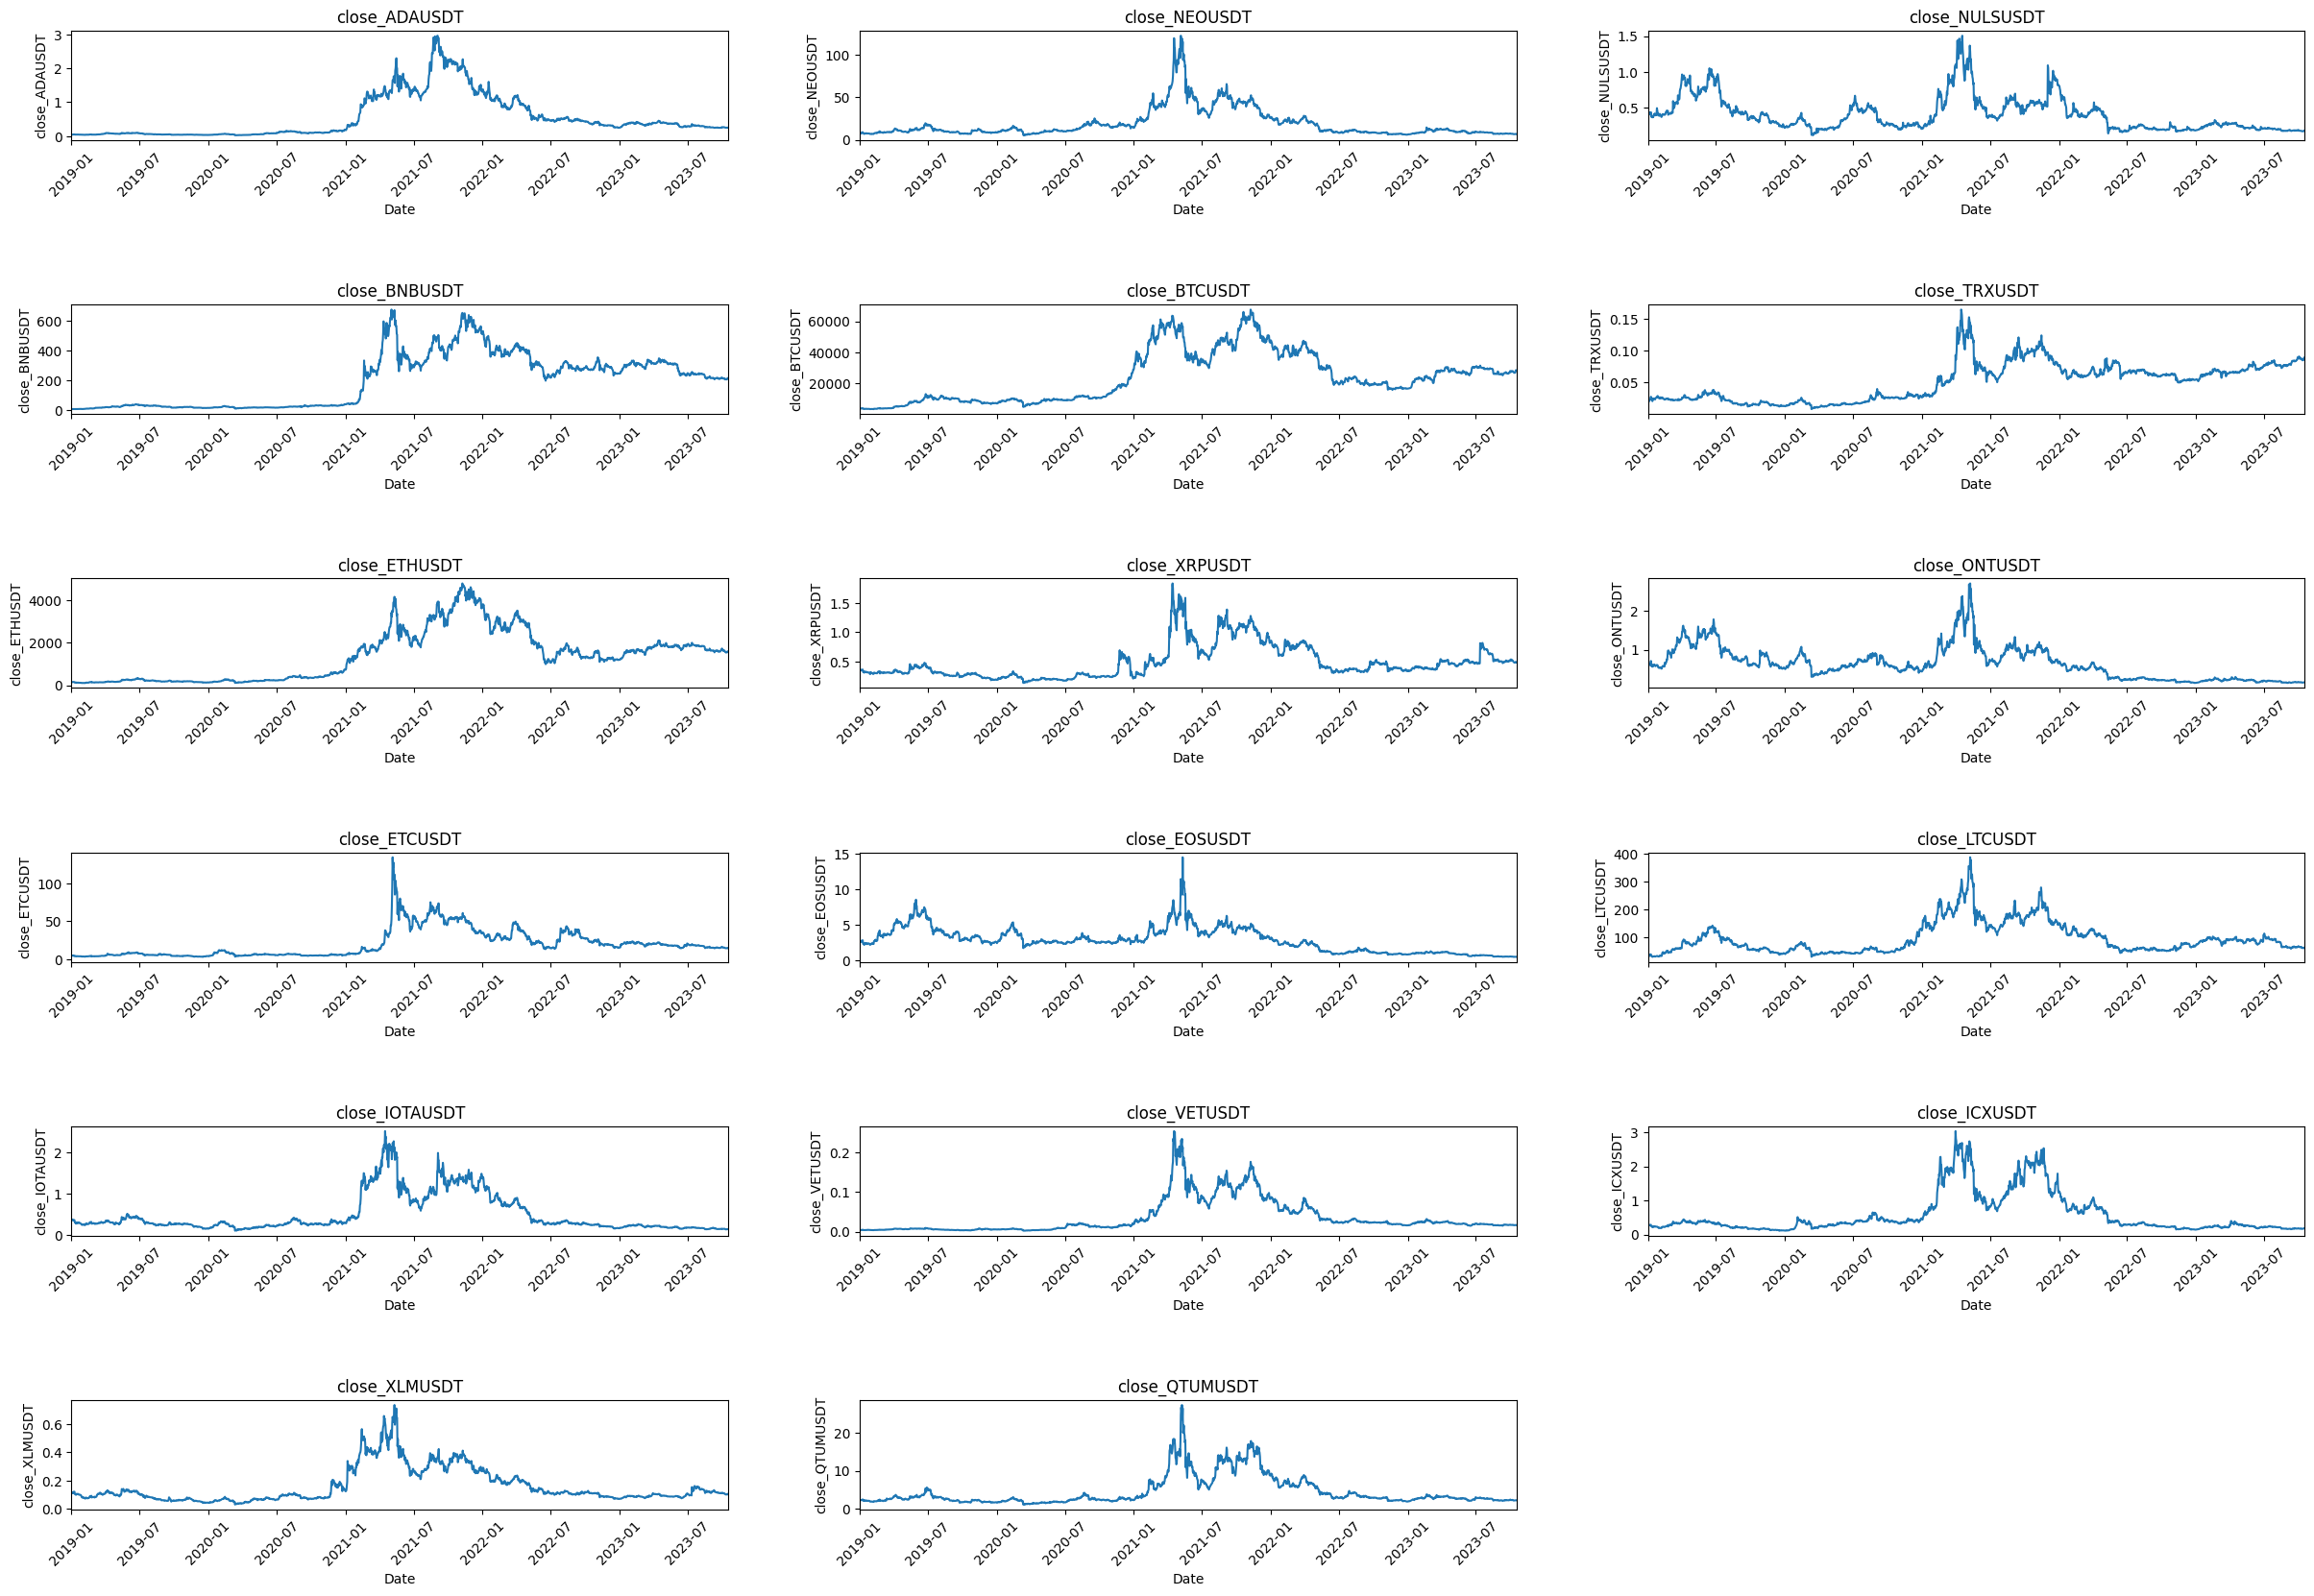

<Figure size 640x480 with 0 Axes>

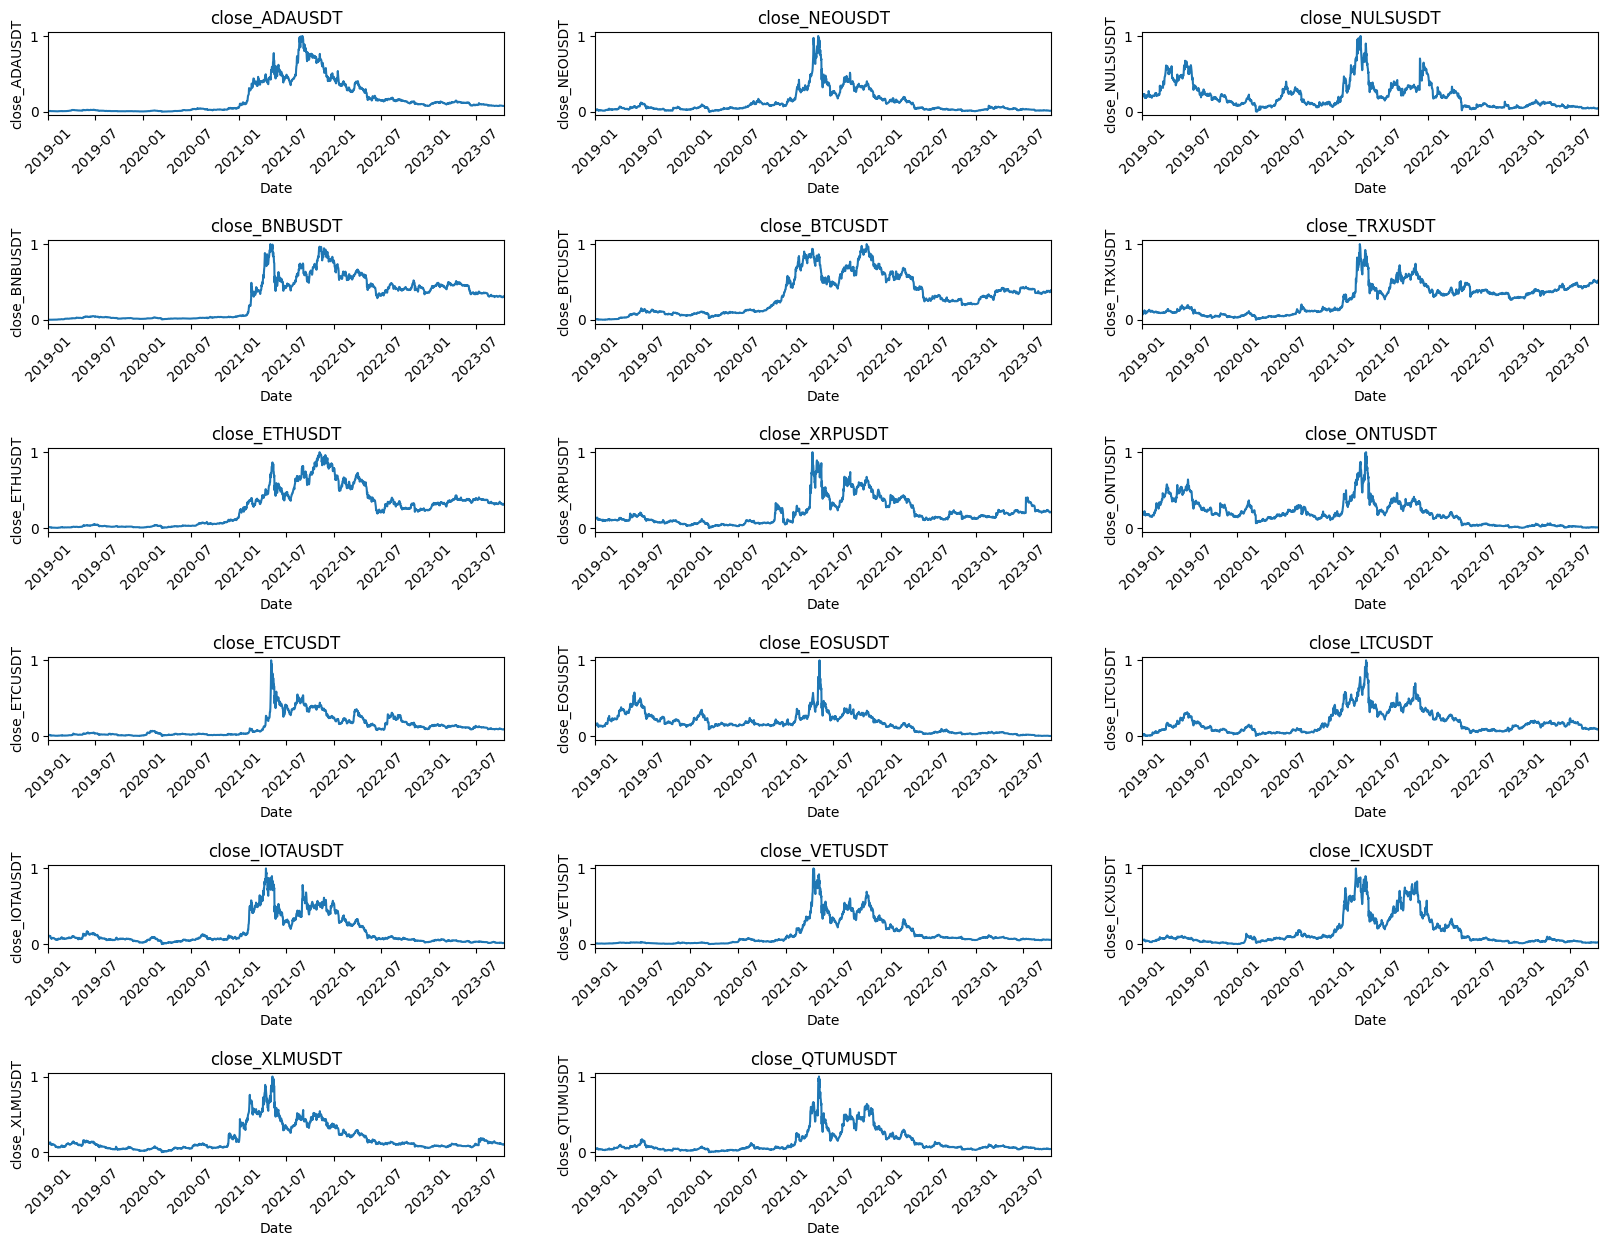

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
# Create subplots with vertical space using Seaborn
chart_rows = math.ceil((merged_df.columns.__len__() - 1) / 3)
plt.figure(figsize=(5*chart_rows, 20))
grid = plt.GridSpec(chart_rows, 3, hspace=1.5)  # Adjust the value of hspace as needed

for i, col in enumerate(merged_df.columns[1:]):
    ax = plt.subplot(grid[i // 3, i % 3])
    sns.lineplot(data=merged_df, x="Date", y=col, ax=ax)
    ax.set_title(col)

    # Rotate x-axis labels to an oblique angle
    plt.xticks(rotation=45)  # You can adjust the angle as needed

    # Set x-axis limits to display the full date range
    ax.set_xlim(merged_df['Date'].min(), merged_df['Date'].max())

plt.savefig("fig.png")
plt.show()
mlflow.log_artifact("fig.png", "time series")


# Create a custom Min-Max scaling function
def custom_min_max_scaling(column):
    min_val = column.min()
    max_val = column.max()
    scaled_column = (column - min_val) / (max_val - min_val)
    return scaled_column

# Scale the numeric columns in the DataFrame (excluding 'date')
numeric_cols = merged_df.columns[1:]
scaled_df = merged_df.copy()
scaled_df[numeric_cols] = scaled_df[numeric_cols].apply(custom_min_max_scaling, axis=0)

# Create subplots with vertical space using Seaborn
plt.figure(figsize=(20, 20))
grid = plt.GridSpec(8, 3, hspace=1.5)  # Adjust the value of hspace as needed

for i, col in enumerate(scaled_df.columns[1:]):
    ax = plt.subplot(grid[i // 3, i % 3])
    sns.lineplot(data=scaled_df, x="Date", y=col, ax=ax)
    ax.set_title(col)

    # Rotate x-axis labels to an oblique angle
    plt.xticks(rotation=45)  # You can adjust the angle as needed

    # Set x-axis limits to display the full date range
    ax.set_xlim(merged_df['Date'].min(), merged_df['Date'].max())


# Display the plots
plt.savefig("fig.png")
plt.show()
mlflow.log_artifact("fig.png")


### Perform PACF

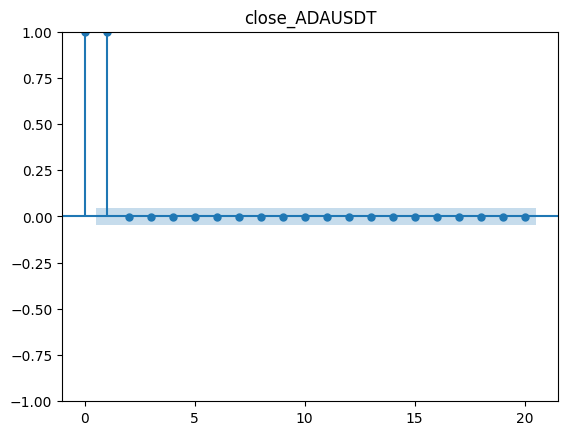

<Figure size 640x480 with 0 Axes>

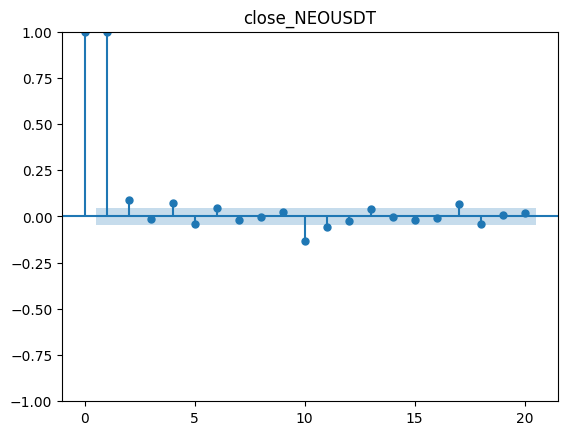

<Figure size 640x480 with 0 Axes>

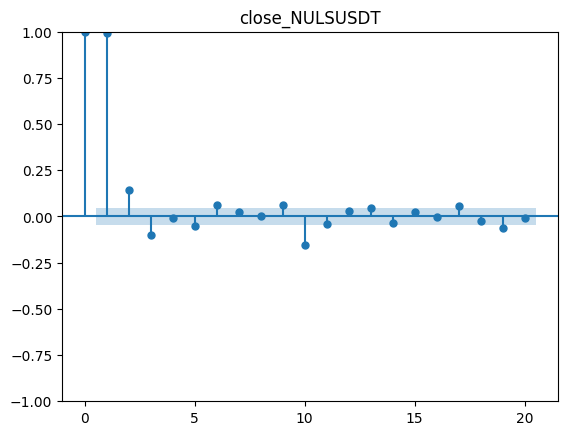

<Figure size 640x480 with 0 Axes>

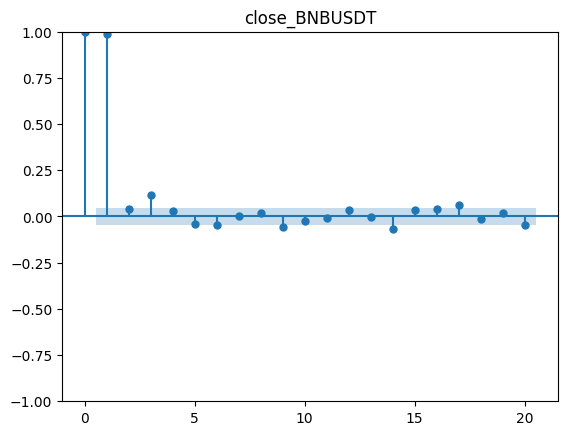

<Figure size 640x480 with 0 Axes>

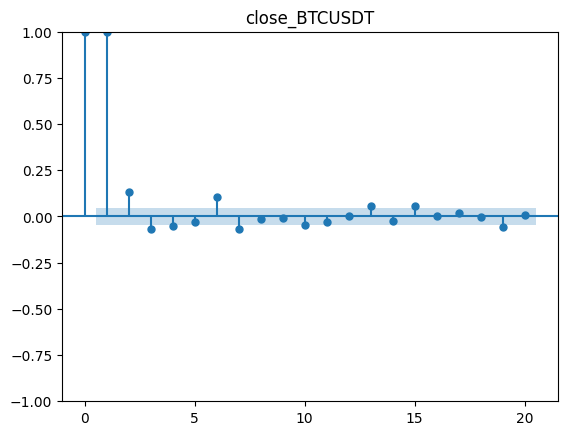

<Figure size 640x480 with 0 Axes>

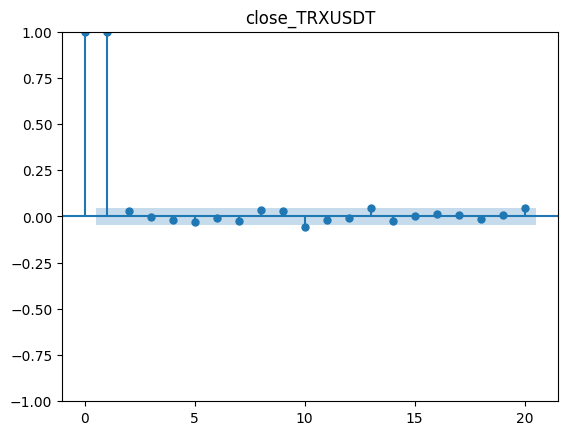

<Figure size 640x480 with 0 Axes>

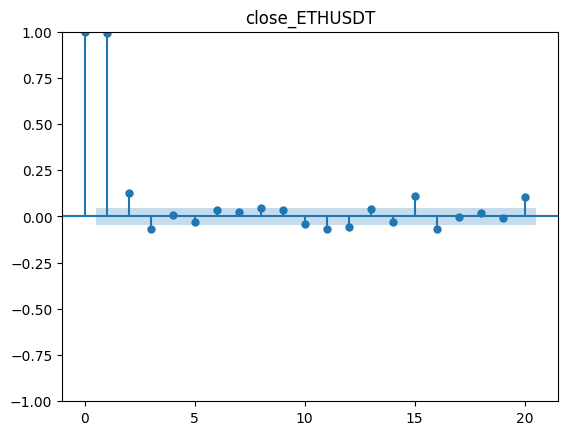

<Figure size 640x480 with 0 Axes>

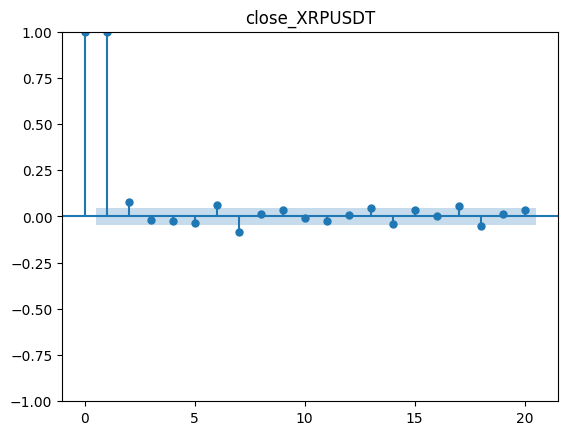

<Figure size 640x480 with 0 Axes>

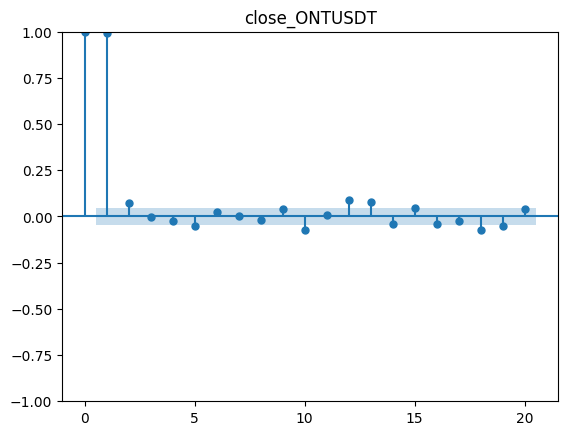

<Figure size 640x480 with 0 Axes>

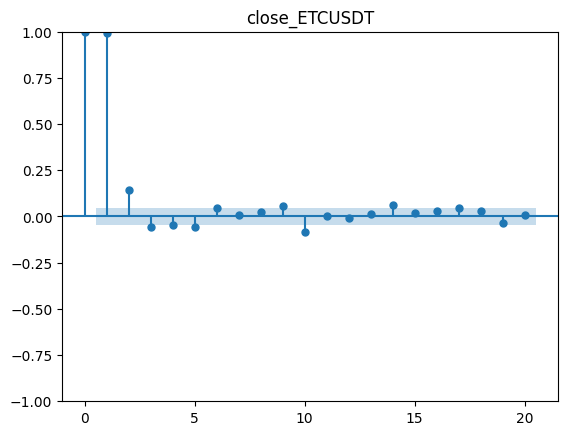

<Figure size 640x480 with 0 Axes>

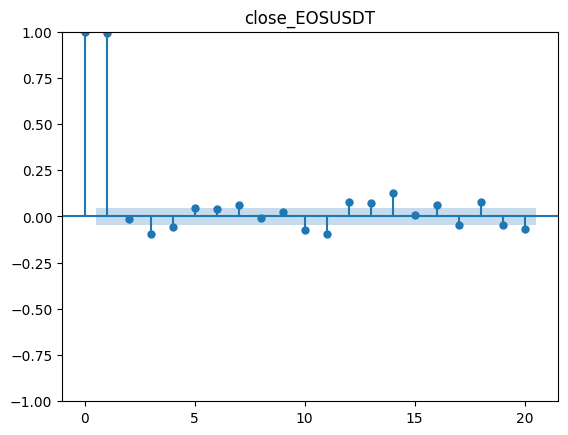

<Figure size 640x480 with 0 Axes>

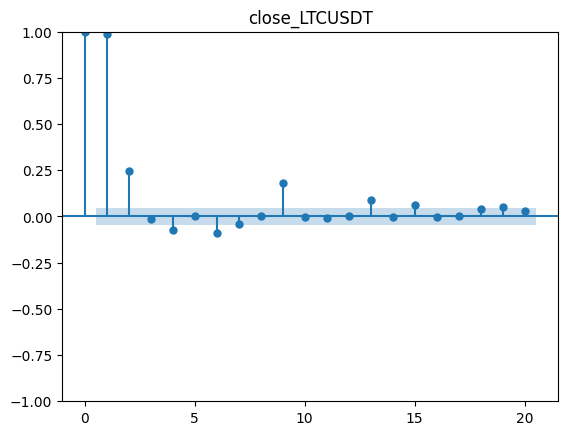

<Figure size 640x480 with 0 Axes>

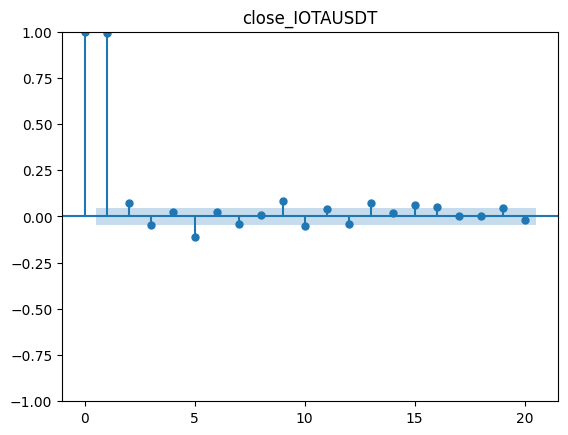

<Figure size 640x480 with 0 Axes>

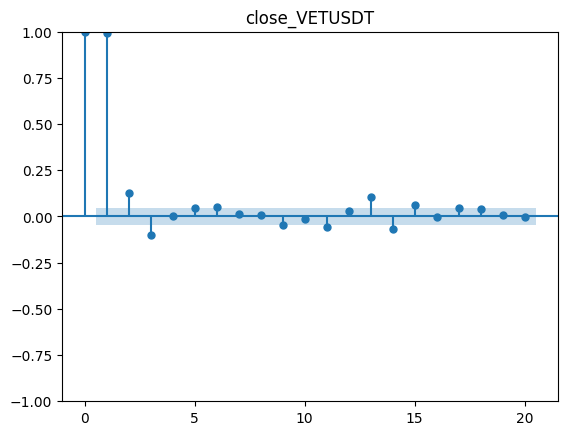

<Figure size 640x480 with 0 Axes>

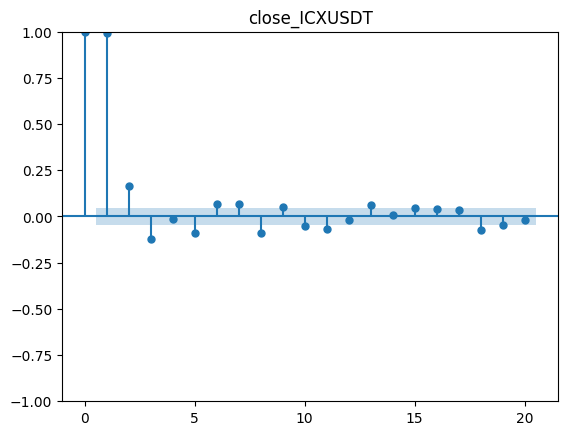

<Figure size 640x480 with 0 Axes>

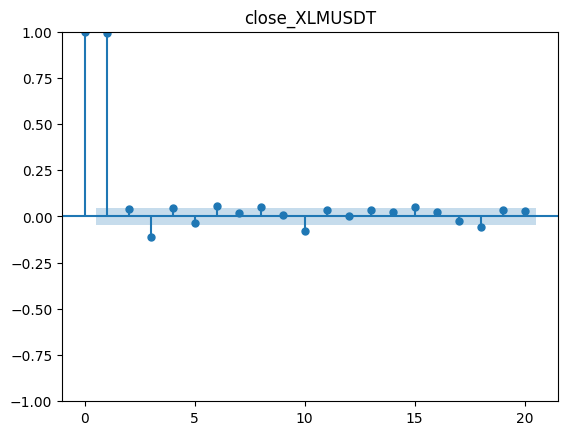

<Figure size 640x480 with 0 Axes>

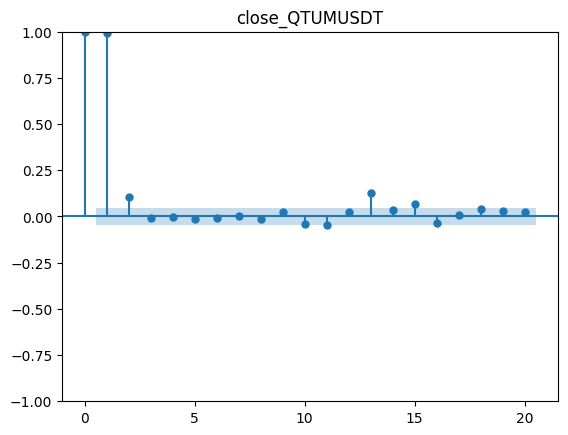

<Figure size 640x480 with 0 Axes>

In [8]:
# Plot PACF for each column of merged_df except the date column using plot_pacf

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.graphics.tsaplots import plot_pacf


# remove the date column in a copy of the scaled_df
data = merged_df.copy()
data.drop(columns=["Date"], inplace=True)

for i, col in enumerate(data.columns):
    # Plot PACF for the column
    plot_pacf(merged_df.iloc[:, i], lags=20, alpha=0.05)
    plt.title(col)
    plt.show()
    plt.savefig("fig.png")
    mlflow.log_artifact("fig.png", f"PACF {col}")


In [9]:
run.end_run()

AttributeError: 'ActiveRun' object has no attribute 'end_run'